# Quant tools

## Getting Data

In [7]:
import os
import datetime
from datetime import date
import tushare as ts
import pandas as pd
import alphalens as al
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 8.0)
pro = ts.pro_api()
# Init today's data.
def init_today():
    # Update Factor
    if os.path.isfile("factors_df.csv"):
        print("Updating Factors Data...")
        factor_df=pd.read_csv("factors_df.csv")
        last_latest_datetime=get_last_latest_time(factor_df)
        wdays=get_wdays(last_latest_datetime,get_today())
        new_factor_df=get_factor_data(wdays)
        update_factor_df=pd.concat([factor_df, new_factor_df])
        update_factor_df.to_csv("factors_df.csv",index=False)
    else:
        print("You haven't got history data, so we are now downloading the factor data...")
        print("It might takes long.")
        wdays=get_wdays('20180101',get_today())
        factor_df=get_factor_data(wdays)
        
        
    
    if os.path.isfile("quotes_df.csv"):
        quotes_df=pd.read_csv("quotes_df.csv")
        last_latest_datetime=get_last_latest_time(quotes_df)
        nquotes=get_quotes_data(get_last_latest_time,get_today())
        update_quotes=pd.concat([quotes_df,nquotes])
        update_quotes.to_csv("quotes_df.csv",index=False)
    else:
        print("You haven't got history data, so we are now downloading the quotes data...")
        print("It might takes long.")
        nquotes=get_quotes_data('20180101',get_today())
    print("WE ARE READY FOR TODAY")
        
    
def get_last_latest_time(df):
    last_latest_datetime="20".format(
            df['trade_date'].unique().max().astype('M8[D]').astype(datetime.datetime).strftime('%y%m%d')
        )
    return last_latest_datetime

def get_wdays(start_date,end_date):
    wdays = pro.trade_cal(exchange_id='', start_date=start_date, end_date=end_date)
    wdays = wdays[wdays.is_open==1].cal_date.values.tolist()
    return wdays
        

def get_today():
    return "20{}".format(date.today().strftime('%y%m%d'))

# Transforming datetime
def transform_datetime(df):
    df['trade_date']=df['trade_date'].apply(lambda x:pd.to_datetime(x))
    return df

# Setting Factor
def set_factor(factor_df, factor):
    factor = factor_df.loc[:,['ts_code','trade_date',factor]].set_index(['trade_date','ts_code'])
    factor = factor.unstack().fillna(method='ffill').stack()
    return factor

def get_all_tickers():
    return pro.query('stock_basic', exchange='', list_status='L', fields='ts_code')['ts_code']

def get_quotes_data(start_date,end_date):
    tickers=get_all_tickers()
    quote_list=[]
    for ticker in tqdm(tickers):
        temp_quote=ts.pro_bar(ticker,start_date=start_date,end_date=end_date)
        temp_quote=temp_quote[['trade_date','close']]
        quote_list.append(temp_quote)
    quotes_df=pd.concat(quote_list)
    print("Transforming")
    quotes_df=transform_datetime(quotes_df)
    print("Saving Quotes Data...")
    quotes_df.to_csv('quotes_df.csv',index=False)
    print("Quotes Data Saved.")
    return quotes_df

def get_factor_data(wdays):
    factors_list = []
    for idate in tqdm(wdays):
        temp_df = pro.query('daily_basic', ts_code='', trade_date=idate)
        factors_list.append(temp_df)
    factor_df = pd.concat(factors_list)
    print("Transforming")
    factor_df=transform_datetime(factor_df)
    print("Saving Factor Data...")
    factor_df.to_csv('factor_df.csv',index=False)
    print("Factor Data Saved.")
    return factor_df

# Reshape for alphalens
# prices = quotes.pivot(index='trade_date',columns='ts_code',values='close')

# init_today()

## Backtesting

In [82]:
ts_code='600515.SH'
start_date='20180101'
end_date='20200831'
data_path = './data/'
if not os.path.exists(data_path):
    os.makedirs(data_path)
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )
    def __init__(self):
        super().__init__()
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=1)  # enter long
                # self.buy()
        elif self.crossover < 0:  # in the market & cross to the downside
            self.order_target_size(target=0)  # close long position
            # self.close()

class Strategy_runner:
    def __init__(self, strategy, ts_code, start_date, end_date, data_path=data_path, pro=False, token='b0b77de137ce7867c95f053ee8e10a5607f6787201a252aca20f98db'):
        self.ts_code = ts_code
        self.start_date = start_date
        self.end_date = end_date
        # convert to datetime
        self.start_datetime = datetime.datetime.strptime(start_date,'%Y%m%d')
        self.end_datetime = datetime.datetime.strptime(end_date,'%Y%m%d')
        
        if pro:
            csv_name = f'pro_day_{str(ts_code)}-{str(start_date)}-{str(end_date)}.csv'
        else:
            csv_name = f'day_{str(ts_code)}-{str(start_date)}-{str(end_date)}.csv'
        csv_path = os.path.join(data_path,csv_name)
        if os.path.exists(csv_path):
            if pro:
                self.df = pd.read_csv(csv_path)
            else:
                self.df = pd.read_csv(csv_path,index_col=0)
        else:
            if pro:
                ts.set_token(token)
                self.pro = ts.pro_api()
                self.df = self.pro.daily(ts_code=self.ts_code, start_date=self.start_date, end_date=self.end_date)
                if not self.df.empty:
                    self.df.to_csv(csv_path, index=False)
            else:
                self.df = ts.get_hist_data(self.ts_code, str(self.start_datetime), str(self.end_datetime))
                if not self.df.empty:
                    self.df.to_csv(csv_path, index=True)
            
        self.df_bt = self.preprocess(self.df, pro)
        print(self.df_bt)
        self.strategy = strategy
        self.cerebro = bt.Cerebro()
        

    def preprocess(self, df, pro=False):
        if pro:
            features=['open','high','low','close','vol','trade_date']
            # convert_datetime = lambda x:datetime.strptime(x,'%Y%m%d')
            convert_datetime = lambda x: pd.to_datetime(str(x))
            df['trade_date'] = df['trade_date'].apply(convert_datetime)
            print(df)
            bt_col_dict = {'vol':'volume','trade_date':'datetime'}
            df = df.rename(columns=bt_col_dict)
            df = df.set_index('datetime')
            # df.index = pd.DatetimeIndex(df.index)
        else:
            features=['open','high','low','close','volume']
            df = df[features]
            df['openinterest'] = 0
            df.index = pd.DatetimeIndex(df.index)

        df = df[::-1]
        return df

    def run(self):
        data = bt.feeds.PandasData(dataname=self.df_bt,                               
                                    fromdate=self.start_datetime,                               
                                    todate=self.end_datetime)
        self.cerebro.adddata(data)  # Add the data feed
        self.cerebro.addstrategy(self.strategy)  # Add the trading strategy
        self.cerebro.broker.setcash(1000000.0)
        self.cerebro.addsizer(bt.sizers.FixedSize, stake=10)
        self.cerebro.broker.setcommission(commission=0.0005)
        self.cerebro.addanalyzer(bt.analyzers.SharpeRatio,_name = 'SharpeRatio')
        self.cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
        self.results = self.cerebro.run()
        strat = self.results[0]
        print('Final Portfolio Value: %.2f' % self.cerebro.broker.getvalue())
        print('SR:', strat.analyzers.SharpeRatio.get_analysis())
        print('DW:', strat.analyzers.DW.get_analysis())
        return self.results
    
    def plot(self, iplot=False):
        self.cerebro.plot(iplot=iplot)

In [86]:
strategy_runner = Strategy_runner(strategy=SmaCross, ts_code=ts_code, start_date=start_date, end_date=end_date, pro=True)
results = strategy_runner.run()

       ts_code trade_date   open   high    low  close  pre_close  change  \
0    600515.SH 2020-08-11   7.71   8.00   7.19   7.23       7.75   -0.52   
1    600515.SH 2020-08-10   7.52   8.14   7.40   7.75       7.51    0.24   
2    600515.SH 2020-08-07   6.83   7.51   6.62   7.51       6.83    0.68   
3    600515.SH 2020-08-06   6.62   6.97   6.55   6.83       6.65    0.18   
4    600515.SH 2020-08-05   6.56   6.74   6.44   6.65       6.62    0.03   
..         ...        ...    ...    ...    ...    ...        ...     ...   
495  600515.SH 2018-01-08  11.80  12.20  11.48  11.84      11.95   -0.11   
496  600515.SH 2018-01-05  11.84  12.09  11.73  11.95      11.81    0.14   
497  600515.SH 2018-01-04  11.95  12.00  11.70  11.81      11.90   -0.09   
498  600515.SH 2018-01-03  11.99  11.99  11.68  11.90      11.99   -0.09   
499  600515.SH 2018-01-02  11.83  12.10  11.75  11.99      11.83    0.16   

     pct_chg         vol       amount  
0    -6.7097  1277688.78   973800.240  
1     3

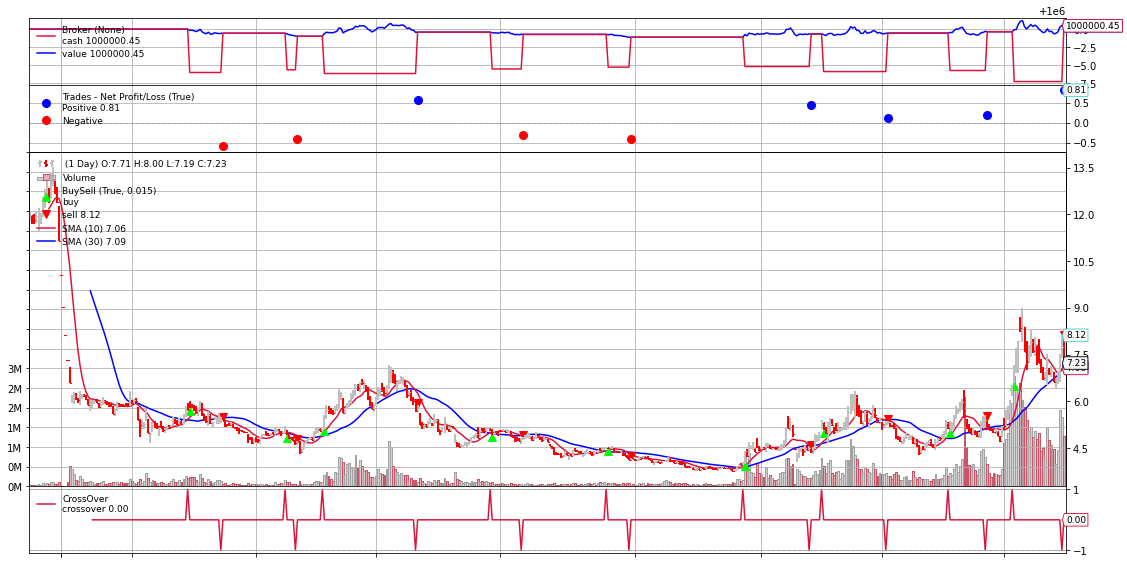

In [93]:
strategy_runner.plot()
plt.show()